# Contrast Limited Adaptive Histogram Equalisation

This notebook demonstrate how to "enhances" an image contrast using a method called histogram equalisation. In this example we will use the algorithm [CLAHE](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization).

This work was adapted from [Hugo Raveton's implementation](https://github.com/HugoRaveton/pyopencl_clahe) 

In [1]:
import pyclesperanto as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

cle.select_device()

(OpenCL) AMD Ryzen 9 7950X 16-Core Processor (OpenCL 3.0 (Build 0))
	Vendor:                      Intel(R) Corporation
	Driver Version:              2025.20.10.0.23_160000
	Device Type:                 CPU
	Compute Units:               32
	Global Memory Size:          127926 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         63963 MB
	Max Clock Frequency:         0 MHz
	Image Support:               Yes

## Load some dataset

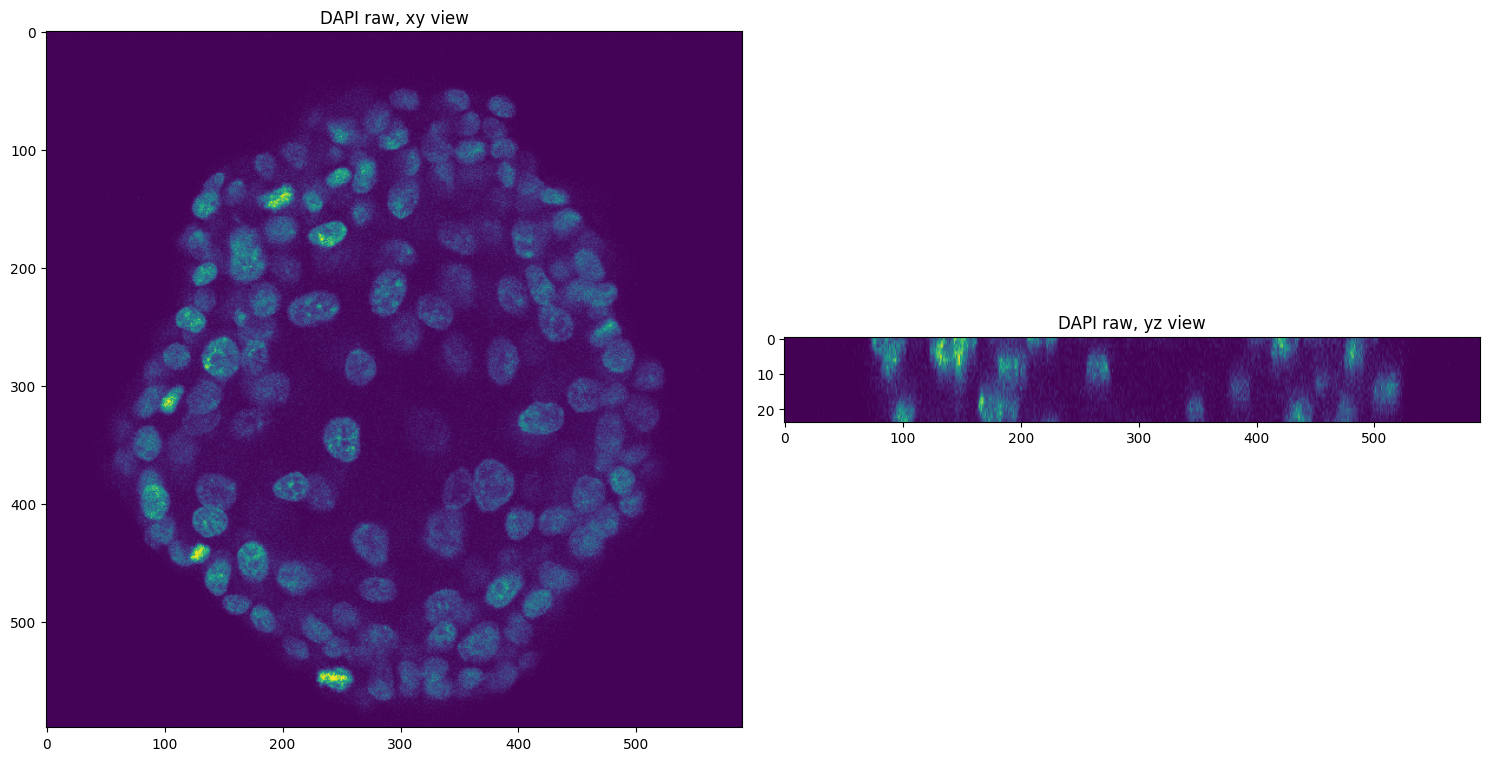

In [2]:
image = "https://github.com/StRigaud/pyopencl_clahe/raw/refs/heads/main/Test_image/TOrg2%20DAPI-1.tif"
raw = imread(image)
halfz = int(np.shape(raw)[0]/2)
halfx = int(np.shape(raw)[2]/2)

fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].imshow(raw[halfz], cmap="viridis")
axs[1].imshow(raw[:,halfx,:], aspect = 3, cmap="viridis")
axs[0].set_title('DAPI raw, xy view')
axs[1].set_title('DAPI raw, yz view')
# for ax in axs.ravel():
#     ax.axis('off')
plt.tight_layout()
plt.show()

## CLAHE doc and usage

In [3]:
print(cle.clahe.__doc__)

Applies CLAHE (Contrast Limited Adaptive Histogram Equalization) to the input
image. The algorithm is adapted from the work of Hugo Raveton
(https://github.com/HugoRaveton/pyopencl_clahe).

Parameters
----------
input_image: Image
    Input image to process.
output_image: Optional[Image] (= None)
    Output result image.
tile_size: int (= 8)
    Size of the tiles used for CLAHE.
clip_limit: float (= 0.01)
    Clip limit for CLAHE.
minimum_intensity: float (= float('nan'))
    Minimum intensity value.
maximum_intensity: float (= float('nan'))
    Maximum intensity value.
device: Optional[Device] (= None)
    Device to perform the operation on.

Returns
-------
Image



In [4]:
results_gpu = cle.clahe(raw, tile_size=8, clip_limit=0.01)

### Let's compare the output

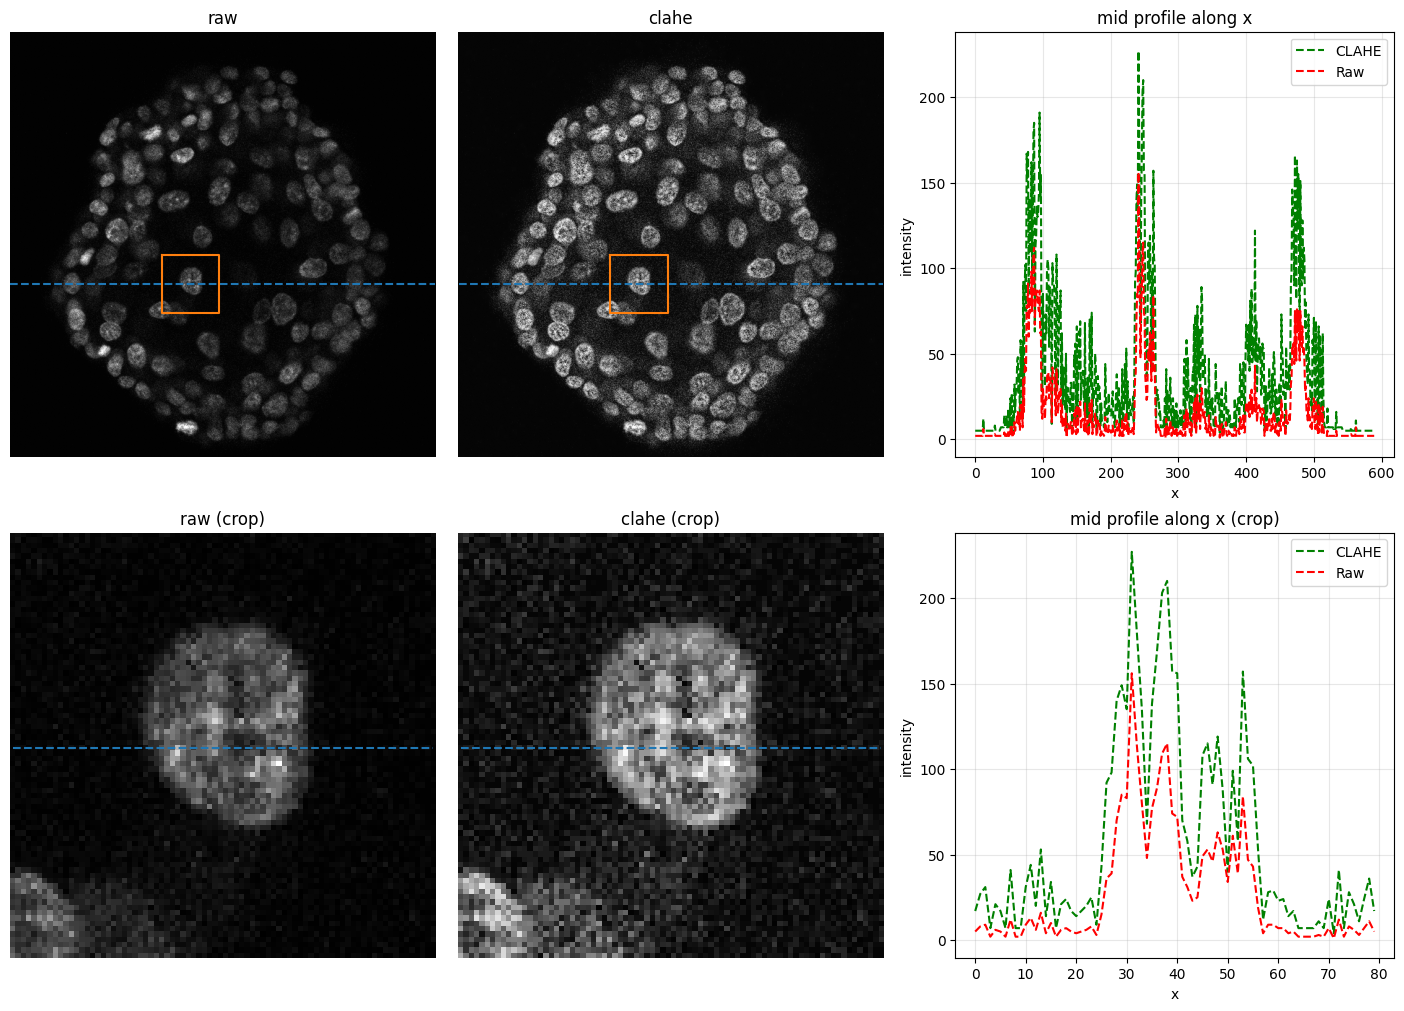

In [5]:
result = results_gpu.get()

radius = 40
corner = [350, 250]
crop_raw = raw[np.shape(raw)[0]//2, corner[0]-radius:corner[0]+radius, corner[1]-radius:corner[1]+radius]
crop_res = result[np.shape(raw)[0]//2, corner[0]-radius:corner[0]+radius, corner[1]-radius:corner[1]+radius]

profile_raw = raw[np.shape(raw)[0]//2, 350, :]
profile_pro = result[np.shape(raw)[0]//2, 350, :]
profile_raw_crop = crop_raw[crop_raw.shape[0]//2, :]
profile_pro_crop = crop_res[crop_res.shape[0]//2, :]

fig, axs = plt.subplots(2, 3, figsize=(14, 10), constrained_layout=True)

axs[0, 0].imshow(raw[np.shape(raw)[0]//2], cmap="gray")
axs[0, 0].set_title("raw")
axs[0, 0].set_axis_off()
axs[0, 0].plot([0, raw.shape[2]-1],[350, 350], "--")
axs[0, 0].plot([corner[1]-radius, corner[1]+radius, corner[1]+radius, corner[1]-radius, corner[1]-radius],
               [corner[0]-radius, corner[0]-radius, corner[0]+radius, corner[0]+radius, corner[0]-radius])
    
axs[0, 1].imshow(result[halfz], cmap="gray")
axs[0, 1].set_title("clahe")
axs[0, 1].set_axis_off()
axs[0, 1].plot([0, result.shape[2]-1],[350, 350], "--")
axs[0, 1].plot([corner[1]-radius, corner[1]+radius, corner[1]+radius, corner[1]-radius, corner[1]-radius],
               [corner[0]-radius, corner[0]-radius, corner[0]+radius, corner[0]+radius, corner[0]-radius])

x_full = np.arange(profile_pro.size)
axs[0, 2].plot(x_full, profile_pro, "--", color="g", label="CLAHE")
axs[0, 2].plot(x_full, profile_raw, "--", color="r", label="Raw")
axs[0, 2].set_title("mid profile along x")
axs[0, 2].set_xlabel("x")
axs[0, 2].set_ylabel("intensity")
axs[0, 2].grid(alpha=0.3)
axs[0, 2].legend(frameon=True)

axs[1, 0].imshow(crop_raw, cmap="gray")
axs[1, 0].set_title("raw (crop)")
axs[1, 0].set_axis_off()
axs[1, 0].plot([0, crop_raw.shape[1]-1],[crop_raw.shape[0]//2, crop_raw.shape[0]//2], "--")

axs[1, 1].imshow(crop_res, cmap="gray")
axs[1, 1].set_title("clahe (crop)")
axs[1, 1].set_axis_off()
axs[1, 1].plot([0, crop_res.shape[1]-1],[crop_res.shape[0]//2, crop_res.shape[0]//2], "--")

x_crop = np.arange(profile_pro_crop.size)
axs[1, 2].plot(x_crop, profile_pro_crop, "--", color="g", label="CLAHE")
axs[1, 2].plot(x_crop, profile_raw_crop, "--", color="r", label="Raw")
axs[1, 2].set_title("mid profile along x (crop)")
axs[1, 2].set_xlabel("x")
axs[1, 2].set_ylabel("intensity")
axs[1, 2].grid(alpha=0.3)
axs[1, 2].legend(frameon=True)

ymin = np.nanmin([
    np.nanmin(profile_pro), np.nanmin(profile_raw),
    np.nanmin(profile_pro_crop), np.nanmin(profile_raw_crop)
])
ymax = np.nanmax([
    np.nanmax(profile_pro), np.nanmax(profile_raw),
    np.nanmax(profile_pro_crop), np.nanmax(profile_raw_crop)
])
pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
for ax in (axs[0, 2], axs[1, 2]):
    ax.set_ylim(ymin - pad, ymax + pad)

plt.show()

The algorithm also works in 3D ...

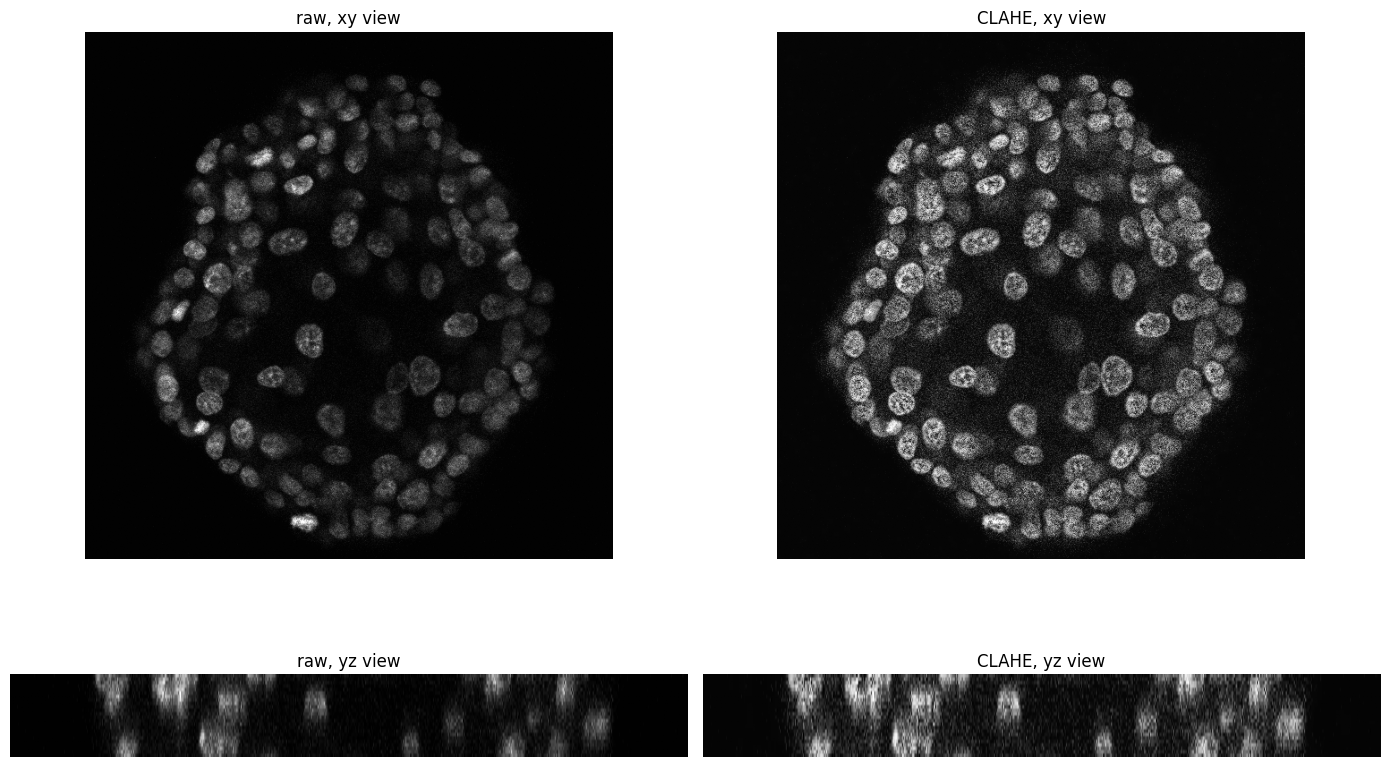

In [6]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
axs[0][0].imshow(raw[halfz], cmap="gray")
axs[0][1].imshow(results_gpu[halfz], cmap="gray")
axs[1][0].imshow(raw[:,halfx,:], aspect = 3, cmap="gray")
axs[1][1].imshow(results_gpu[:,halfx,:], aspect = 3, cmap="gray")
axs[0][0].set_title('raw, xy view')
axs[0][1].set_title('CLAHE, xy view')
axs[1][0].set_title('raw, yz view')
axs[1][1].set_title('CLAHE, yz view')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()

Thanks for following this demos of CLAHE !